<a href="https://colab.research.google.com/github/BrainConnection/QuTiP/blob/main/Project%20Dynamic%20Decoupling/Noise%20Practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Environment Setting

In [1]:
!pip install qutip
!pip install numpy
!pip install matplotlib
!pip install scipy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.3/16.3 MB 50.7 MB/s eta 0:00:00


In [2]:
from qutip import *
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate
from scipy.optimize import curve_fit
from numpy.random import uniform

/usr/local/lib/python3.10/dist-packages/qutip/__init__.py:66: UserWarning: The new version of Cython, (>= 3.0.0) is not supported.
  warnings.warn(


#4. Ambrozy Electronic Noise

### (1) Deterministic Signal

In [3]:
tlist = np.linspace(-10, 10, 1000)

omega_0 = 2*np.pi*0.2

u_1 = np.sin(omega_0*tlist + np.pi/4)

Text(0, 0.5, 'Expectation Value')

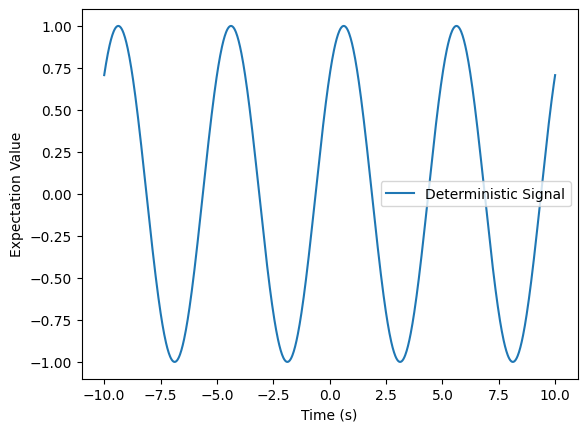

In [4]:
# Deterministic Function

fig, ax = plt.subplots(1, 1)
ax.plot(tlist, u_1, label = 'Deterministic Signal')
ax.legend(loc = 0)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Expectation Value')

In [5]:
tau_list = np.linspace(-5, 5, 100)

def Gamma(tau):

    lst = []
    for i in range(100):
      u_1 = np.sin(omega_0*tlist + np.pi/4)
      u_1_ = np.sin(omega_0*tlist + omega_0*tau[i] + np.pi/4)
      u_mult = u_1 * u_1_

      n = 0
      for j in range(1000):
        n = n + u_mult[j]

      lst.append(n/1000)

    return np.array(lst)

Text(0, 0.5, 'Auto Correlation')

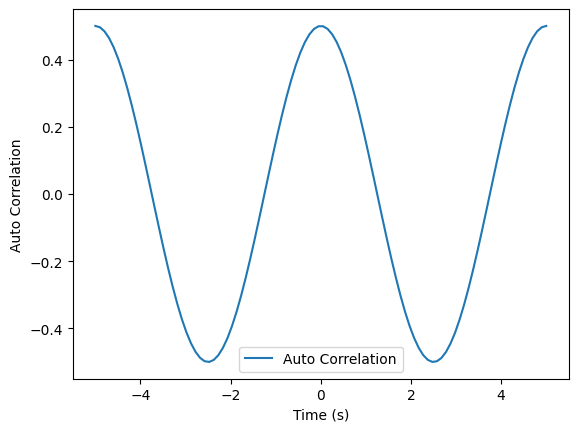

In [6]:
fig, ax = plt.subplots(1, 1)
ax.plot(tau_list, Gamma(tau_list), label = 'Auto Correlation')
ax.legend(loc = 0)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Auto Correlation')

Text(0, 0.5, 'Spectral Density')

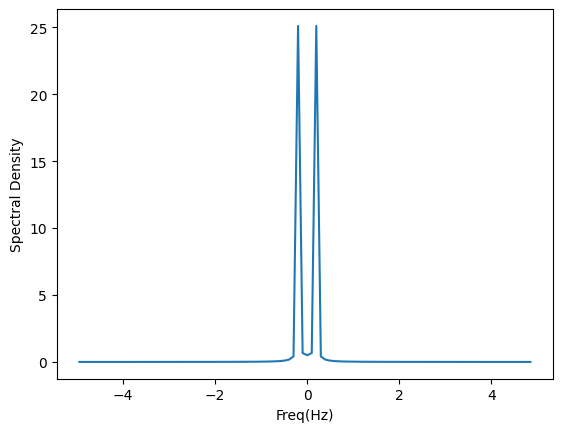

In [7]:
Gamma_fft = np.fft.fftshift(np.fft.fft(Gamma(tau_list)))
Gamma_freq = np.fft.fftshift(np.fft.fftfreq(len(Gamma(tau_list)), d=tau_list[1]-tau_list[0]))

plt.figure()
plt.plot(Gamma_freq, np.abs(Gamma_fft))
#plt.xlim(0,0.1)
plt.xlabel('Freq(Hz)')
plt.ylabel('Spectral Density')

### (2) Shot Noise with one trace

In [8]:
# Shot Noise

mu, sigma = 0, 1 # mean and standard deviation
s = np.random.normal(mu, sigma, 1000)

lst = []
for i in range(1000):
  for j in range(10):
    lst.append(s[i])

arr = np.array(lst)

In [9]:
gamma_list = []

for tau in range(-100, 100, 1):
  n = 0

  for i in range(1000, 9000, 1):
    n = n + arr[i]*arr[i+tau]

  gamma_list.append(n/8000)

gamma = np.array(gamma_list)
tau_list = np.array(range(-100, 100, 1))

Text(0, 0.5, 'Auto Correlation')

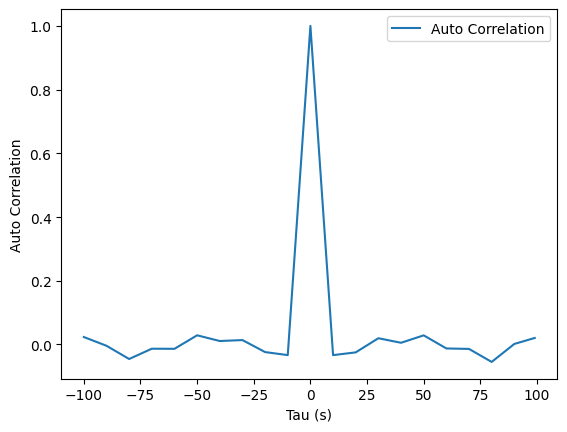

In [10]:
fig, ax = plt.subplots(1, 1)
ax.plot(tau_list, gamma, label = 'Auto Correlation')
ax.legend(loc = 0)
ax.set_xlabel('Tau (s)')
ax.set_ylabel('Auto Correlation')

Text(0, 0.5, 'Spectral Densitys Absolute Value')

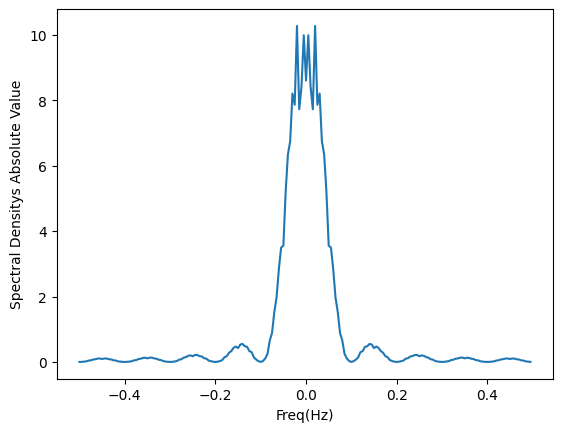

In [11]:
Gamma_fft = np.fft.fftshift(np.fft.fft(gamma))
Gamma_freq = np.fft.fftshift(np.fft.fftfreq(len(gamma), d=tau_list[1]-tau_list[0]))

plt.figure()
plt.plot(Gamma_freq, np.abs(Gamma_fft))
#plt.xlim(0,0.1)
plt.xlabel('Freq(Hz)')
plt.ylabel('Spectral Density''s Absolute Value')

### (3) White Noise with one trace

In [12]:
# Random Noise

mu, sigma = 0, 1 # mean and standard deviation
s = np.random.normal(mu, sigma, 10000)

arr = np.array(s)

In [13]:
gamma_list = []

for tau in range(-100, 100, 1):
  n = 0

  for i in range(1000, 9000, 1):
    n = n + arr[i]*arr[i+tau]

  gamma_list.append(n/8000)

gamma = np.array(gamma_list)
tau_list = np.array(range(-100, 100, 1))

Text(0, 0.5, 'Auto Correlation')

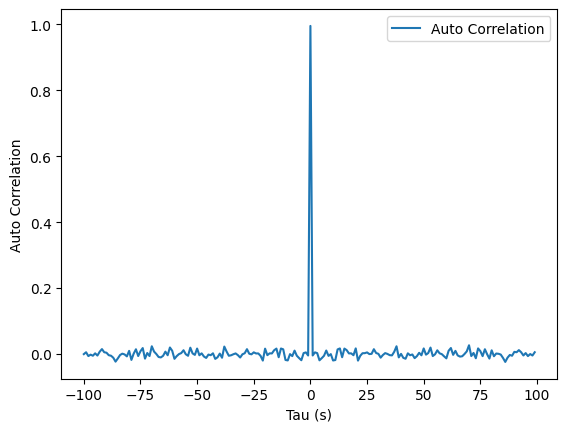

In [14]:
fig, ax = plt.subplots(1, 1)
ax.plot(tau_list, gamma, label = 'Auto Correlation')
ax.legend(loc = 0)
ax.set_xlabel('Tau (s)')
ax.set_ylabel('Auto Correlation')

Text(0, 0.5, 'Spectral Densitys Absolute Value')

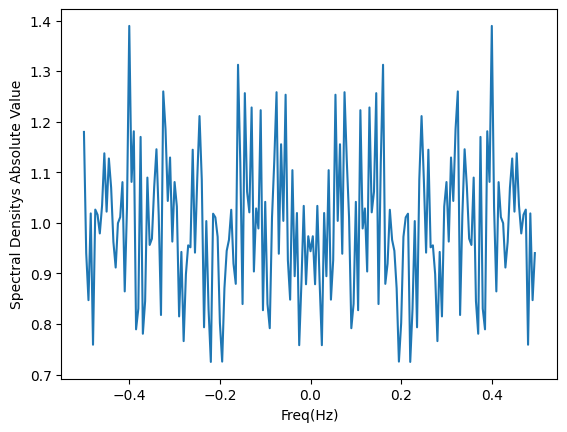

In [15]:
Gamma_fft = np.fft.fftshift(np.fft.fft(gamma))
Gamma_freq = np.fft.fftshift(np.fft.fftfreq(len(gamma), d=tau_list[1]-tau_list[0]))

plt.figure()
plt.plot(Gamma_freq, np.abs(Gamma_fft))
plt.xlabel('Freq(Hz)')
plt.ylabel('Spectral Density''s Absolute Value')

### (4) White Noise with nine trace average

In [16]:
# Random Noise

mu, sigma = 0, 1 # mean and standard deviation

s1 = np.random.normal(mu, sigma, 10000)
s2 = np.random.normal(mu, sigma, 10000)
s3 = np.random.normal(mu, sigma, 10000)
s4 = np.random.normal(mu, sigma, 10000)
s5 = np.random.normal(mu, sigma, 10000)
s6 = np.random.normal(mu, sigma, 10000)
s7 = np.random.normal(mu, sigma, 10000)
s8 = np.random.normal(mu, sigma, 10000)
s9 = np.random.normal(mu, sigma, 10000)

s_avg = []
for i in range(10000):
  s_avg.append((s1[i]+s2[i]+s3[i]+s4[i]+s5[i]+s6[i]+s7[i]+s8[i]+s9[i])/9)

arr = np.array(s_avg)

In [17]:
gamma_list = []

for tau in range(-100, 100, 1):
  n = 0

  for i in range(1000, 9000, 1):
    n = n + arr[i]*arr[i+tau]

  gamma_list.append(n/8000)

gamma = np.array(gamma_list)
tau_list = np.array(range(-100, 100, 1))

Text(0, 0.5, 'Auto Correlation')

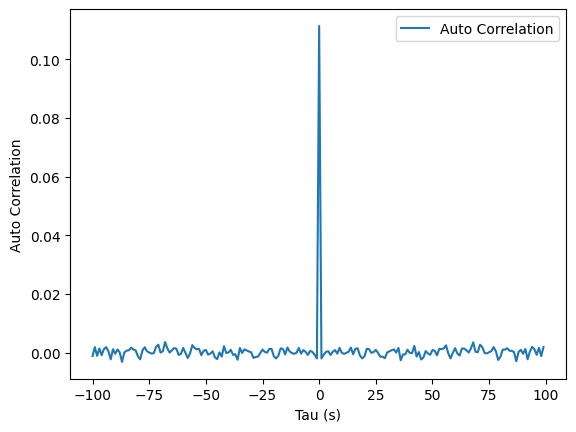

In [18]:
fig, ax = plt.subplots(1, 1)
ax.plot(tau_list, gamma, label = 'Auto Correlation')
ax.legend(loc = 0)
ax.set_xlabel('Tau (s)')
ax.set_ylabel('Auto Correlation')

Text(0, 0.5, 'Spectral Densitys Absolute Value')

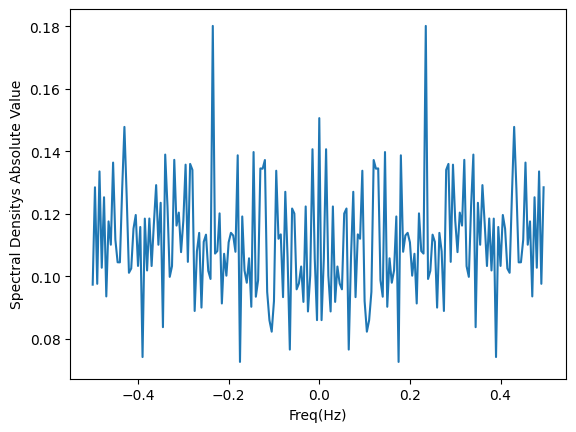

In [19]:
Gamma_fft = np.fft.fftshift(np.fft.fft(gamma))
Gamma_freq = np.fft.fftshift(np.fft.fftfreq(len(gamma), d=tau_list[1]-tau_list[0]))

plt.figure()
plt.plot(Gamma_freq, np.abs(Gamma_fft))
plt.xlabel('Freq(Hz)')
plt.ylabel('Spectral Density''s Absolute Value')

#5. Pink Noise

$$ x(t)=A\left [ \sum_{k=1}^{\infty}\frac{\chi_{k}}{\sqrt{|f_{k}|}}\sin(2\pi f_{k}t+\phi _{k}) \right ] + B \left [ \sum_{k=1}^{\infty}\chi_{k}\sin(2\pi f_{k}t+\phi _{k}) \right ]$$

$$ \chi_{k} \sim \chi(2), \phi_{k} \sim U(0,2\pi) $$

### (1) Uniform Distribution

It's not good strategy to use uniform distribution with multi-traces

Text(0, 0.5, 'Uniform Distribution')

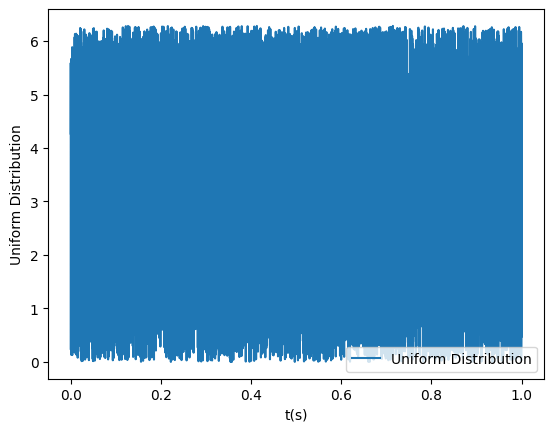

In [20]:
tlist = np.linspace(0, 1, 10000)
U = uniform(0, 2*np.pi, 10000)

fig, ax = plt.subplots(1, 1)
ax.plot(tlist, U, label = 'Uniform Distribution')
ax.legend(loc = 0)
ax.set_xlabel('t(s)')
ax.set_ylabel('Uniform Distribution')

Text(0, 0.5, 'Uniform Distribution')

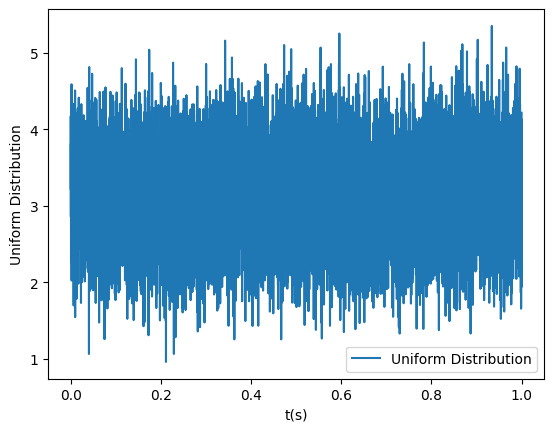

In [21]:
# Not Good

U1 = uniform(0, 2*np.pi, 10000)
U2 = uniform(0, 2*np.pi, 10000)
U3 = uniform(0, 2*np.pi, 10000)
U4 = uniform(0, 2*np.pi, 10000)
U5 = uniform(0, 2*np.pi, 10000)
U6 = uniform(0, 2*np.pi, 10000)
U7 = uniform(0, 2*np.pi, 10000)
U8 = uniform(0, 2*np.pi, 10000)
U9 = uniform(0, 2*np.pi, 10000)

u_avg = []
for i in range(10000):
  u_avg.append((U1[i]+U2[i]+U3[i]+U4[i]+U5[i]+U6[i]+U7[i]+U8[i]+U9[i])/9)

arr = np.array(u_avg)

fig, ax = plt.subplots(1, 1)
ax.plot(tlist, arr, label = 'Uniform Distribution')
ax.legend(loc = 0)
ax.set_xlabel('t(s)')
ax.set_ylabel('Uniform Distribution')

### (2) Normal Distribution with multi-traces

Text(0, 0.5, 'Normal Distribution')

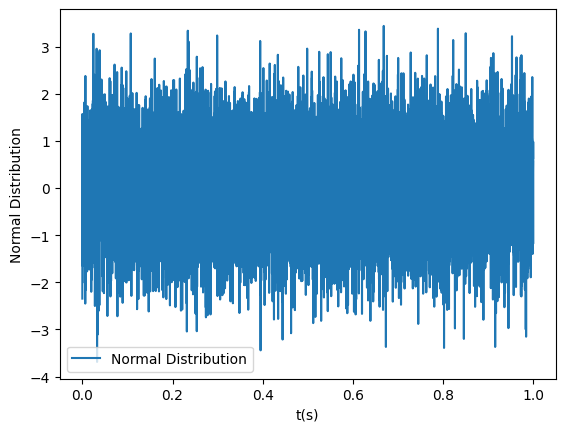

In [22]:
N = np.random.normal(0, 1, 10000)

fig, ax = plt.subplots(1, 1)
ax.plot(tlist, N, label = 'Normal Distribution')
ax.legend(loc = 0)
ax.set_xlabel('t(s)')
ax.set_ylabel('Normal Distribution')

In [23]:
gamma_list = []

for tau in range(-100, 100, 1):
  n = 0

  for i in range(1000, 9000, 1):
    n = n + N[i]*N[i+tau]

  gamma_list.append(n/8000)

gamma = np.array(gamma_list)
tau_list = np.linspace(-0.01, 0.01, 200)

Text(0, 0.5, 'Auto Correlation')

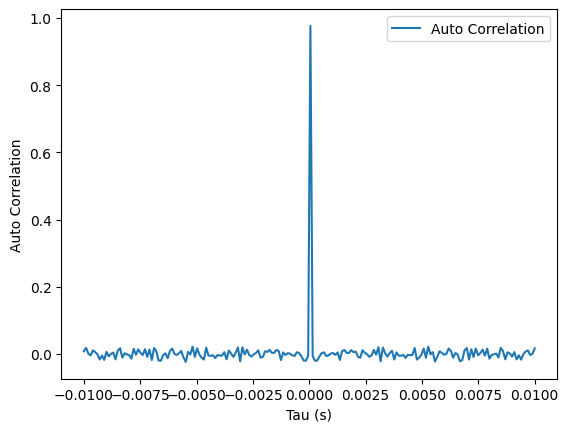

In [24]:
fig, ax = plt.subplots(1, 1)
ax.plot(tau_list, gamma, label = 'Auto Correlation')
ax.legend(loc = 0)
ax.set_xlabel('Tau (s)')
ax.set_ylabel('Auto Correlation')

Text(0, 0.5, 'Spectral Density Absolute Value')

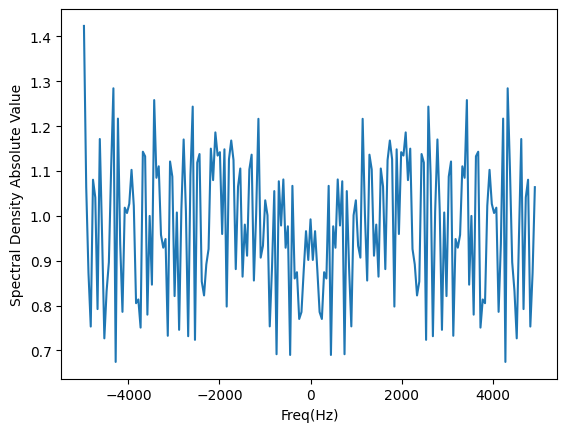

In [25]:
Gamma_fft = np.fft.fftshift(np.fft.fft(gamma))
Gamma_freq = np.fft.fftshift(np.fft.fftfreq(len(gamma), d=tau_list[1]-tau_list[0]))

plt.figure()
plt.plot(Gamma_freq, np.abs(Gamma_fft))
plt.xlabel('Freq(Hz)')
plt.ylabel('Spectral Density Absolute Value')

### (3) Chi Distribution

In [26]:
def Chi_Ensemble (mu, sigma, num_seq):

  X = np.random.normal(mu, sigma, num_seq)
  Y = np.random.normal(mu, sigma, num_seq)

  chi = []

  for i in range(num_seq):
    chi.append(np.sqrt(X[i]**2+Y[i]**2))

  return np.array(chi)

Text(0, 0.5, 'Chi Distribution')

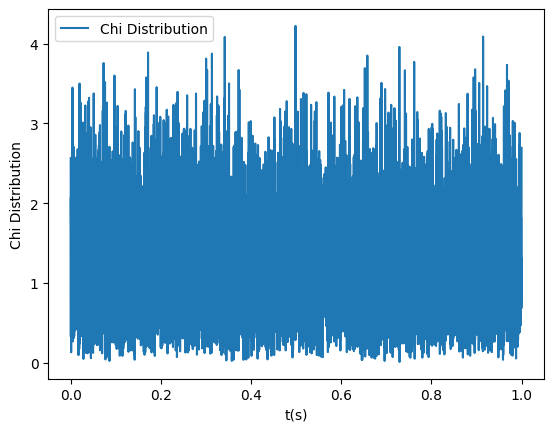

In [27]:
Chi = Chi_Ensemble(0, 1, 10000)

fig, ax = plt.subplots(1, 1)
ax.plot(tlist, Chi, label = 'Chi Distribution')
ax.legend(loc = 0)
ax.set_xlabel('t(s)')
ax.set_ylabel('Chi Distribution')

In [28]:
gamma_list = []

for tau in range(-100, 100, 1):
  n = 0

  for i in range(1000, 9000, 1):
    n = n + Chi[i]*Chi[i+tau]

  gamma_list.append(n/8000)

gamma = np.array(gamma_list)
tau_list = np.linspace(-0.01, 0.01, 200)

Text(0, 0.5, 'Auto Correlation')

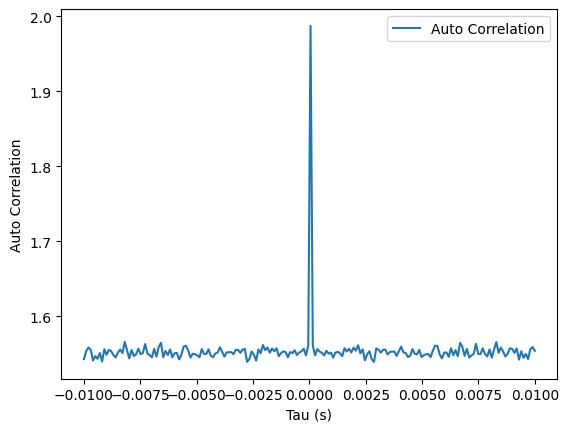

In [29]:
fig, ax = plt.subplots(1, 1)
ax.plot(tau_list, gamma, label = 'Auto Correlation')
ax.legend(loc = 0)
ax.set_xlabel('Tau (s)')
ax.set_ylabel('Auto Correlation')

Text(0, 0.5, 'Spectral Density Absolute Value')

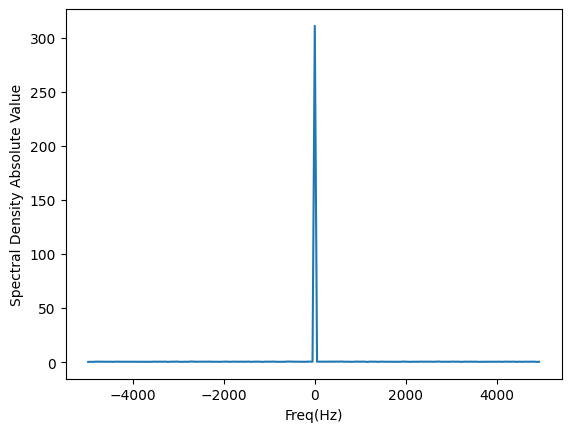

In [30]:
Gamma_fft = np.fft.fftshift(np.fft.fft(gamma))
Gamma_freq = np.fft.fftshift(np.fft.fftfreq(len(gamma), d=tau_list[1]-tau_list[0]))

plt.figure()
plt.plot(Gamma_freq, np.abs(Gamma_fft))
plt.xlabel('Freq(Hz)')
plt.ylabel('Spectral Density Absolute Value')

### (4) Pink Noise (one trace) A=1 B=0

In [31]:
def Pink_Noise(min_freq, freq_repeat, t_end, t_repeat, mu, sigma, A, B):

  tlist = np.linspace(0, t_end, t_repeat)

  Chi_A = Chi_Ensemble(mu, sigma, freq_repeat)
  Chi_B = Chi_Ensemble(mu, sigma, freq_repeat)
  U_A = uniform(0, 2*np.pi, freq_repeat)
  U_B = uniform(0, 2*np.pi, freq_repeat)

  lst = []

  for k in range(freq_repeat):
    lst.append(A * (Chi_A[k]/np.sqrt((k+1)*min_freq)) * np.sin(2*np.pi*(k+1)*min_freq*tlist+U_A[k]) + B * Chi_B[k] * np.sin(2*np.pi*(k+1)*min_freq*tlist+U_B[k]))

  y = []
  for i in range(t_repeat):

    sum = 0
    for k in range(freq_repeat):
      sum = sum + lst[k][i]

    y.append(sum)

  Pink_Noise = np.array(y)

  return Pink_Noise

In [32]:
min_freq = 0.1
freq_repeat = 10000
t_repeat = 10000
t_end = 1

mu = 0
sigma = 0.01

A = 1
B = 0

Text(0, 0.5, 'Pink_Noise Distribution')

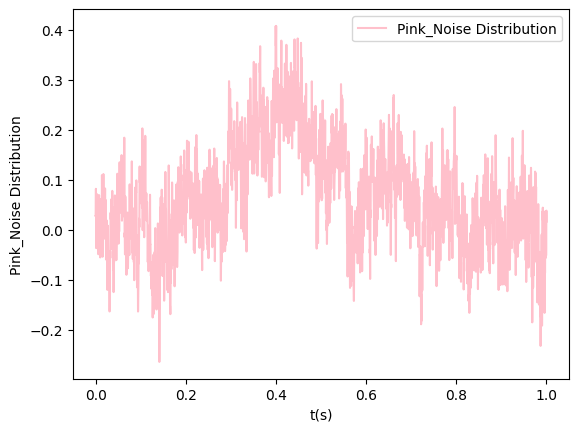

In [33]:
tlist = np.linspace(0, t_end, t_repeat)
Pink_Noise = Pink_Noise(min_freq, freq_repeat, t_end, t_repeat, mu, sigma, A, B)

fig, ax = plt.subplots(1, 1)
ax.plot(tlist, Pink_Noise, label = 'Pink_Noise Distribution', color='pink')
ax.legend(loc = 0)
ax.set_xlabel('t(s)')
ax.set_ylabel('Pink_Noise Distribution')

Text(0, 0.5, 'FT Absolute Value (linear scale)')

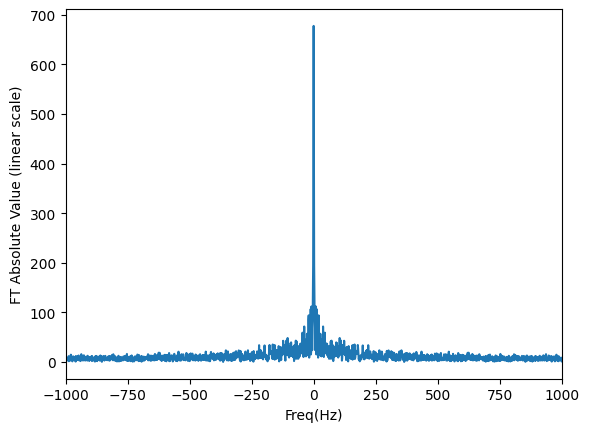

In [34]:
x_fft = np.fft.fftshift(np.fft.fft(Pink_Noise))
x_freq = np.fft.fftshift(np.fft.fftfreq(len(Pink_Noise), d=tlist[1]-tlist[0]))

plt.figure()
plt.plot(x_freq, np.abs(x_fft))
plt.xlim(-1000,1000)
plt.xlabel('Freq(Hz)')
plt.ylabel('FT Absolute Value (linear scale)')

/usr/local/lib/python3.10/dist-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0, 0.5, 'FT Absolute Value (log scale)')

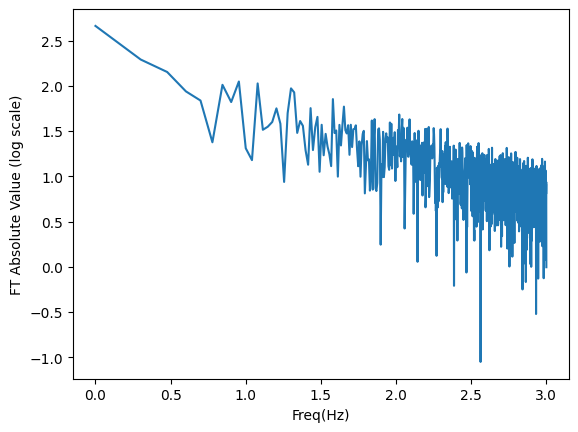

In [35]:
x_fft = np.fft.fftshift(np.fft.fft(Pink_Noise))
x_freq = np.fft.fftshift(np.fft.fftfreq(len(Pink_Noise), d=tlist[1]-tlist[0]))

x_freq_p = x_freq[x_freq > 0]
x_fft_p = x_fft[x_freq > 0]

x_freq_plog = np.log10(x_freq_p[x_freq_p < 1000])
x_fft_plog = np.log10(x_fft_p[x_freq_p < 1000])

plt.figure()
plt.plot(x_freq_plog, x_fft_plog)
plt.xlabel('Freq(Hz)')
plt.ylabel('FT Absolute Value (log scale)')

In [36]:
def func(t, b, a):
    return b + a * t

popt, pcov = curve_fit(func, x_freq_plog, x_fft_plog, p0 = [2, -0.5])

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:625: ComplexWarning: Casting complex values to real discards the imaginary part
  a = asarray(a, dtype=dtype, order=order)


In [37]:
popt

array([ 2.22421916, -0.50226358])

Text(0, 0.5, 'Vertial Position')

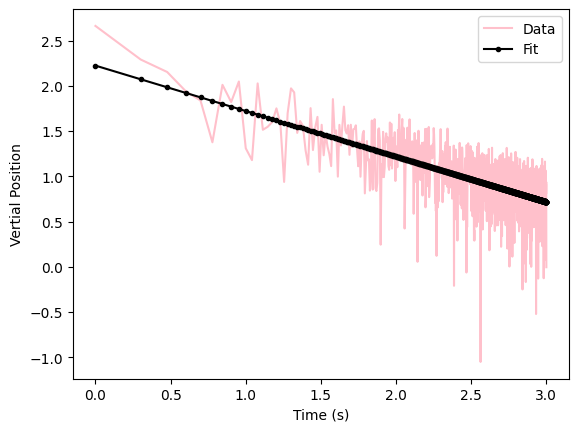

In [38]:
fig, ax = plt.subplots(1, 1)
ax.plot(x_freq_plog, x_fft_plog, label = 'Data', color='pink')
ax.plot(x_freq_plog, func(x_freq_plog, popt[0], popt[1]), marker='.', label = 'Fit', color='black')
ax.legend()
ax.set_xlabel('Time (s)')
ax.set_ylabel('Vertial Position')

In [39]:
gamma_list = []

tau_end = 500
num = 1000


for tau in range(-500, 500, 1):
  n = 0

  for i in range(1000, 9000, 1):
    n = n + Pink_Noise[i]*Pink_Noise[i+tau]

  gamma_list.append(n/8000)

gamma = np.array(gamma_list)
tau_list = np.linspace(-0.05, 0.05, 1000)

Text(0, 0.5, 'Auto Correlation')

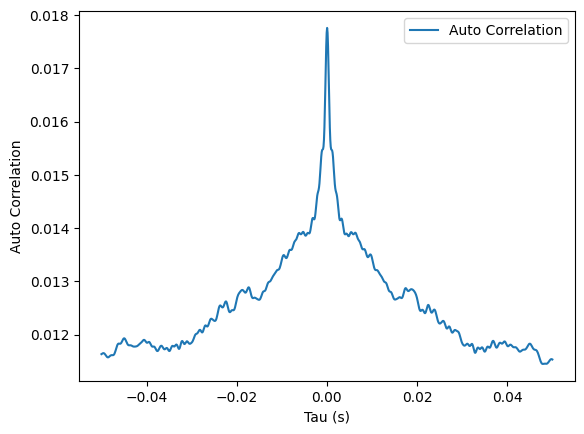

In [40]:
fig, ax = plt.subplots(1, 1)
ax.plot(tau_list, gamma, label = 'Auto Correlation')
ax.legend(loc = 0)
ax.set_xlabel('Tau (s)')
ax.set_ylabel('Auto Correlation')

Text(0, 0.5, 'Spectral Density Absolute Value (linear scale)')

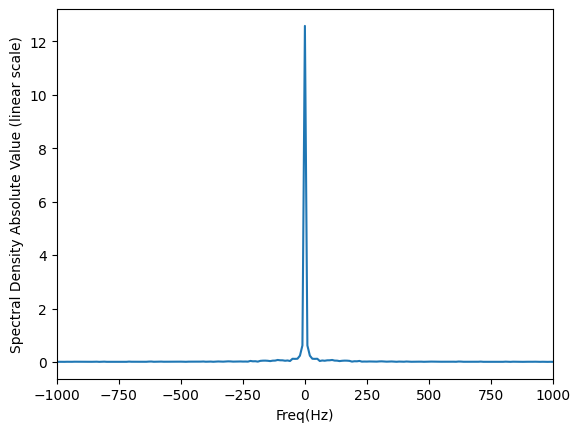

In [41]:
Gamma_fft = np.fft.fftshift(np.fft.fft(gamma))
Gamma_freq = np.fft.fftshift(np.fft.fftfreq(len(gamma), d=tau_list[1]-tau_list[0]))

plt.figure()
plt.plot(Gamma_freq, np.abs(Gamma_fft))
plt.xlim(-1000,1000)
plt.xlabel('Freq(Hz)')
plt.ylabel('Spectral Density Absolute Value (linear scale)')

Text(0, 0.5, 'Spectral Density Absolute Value (log scale)')

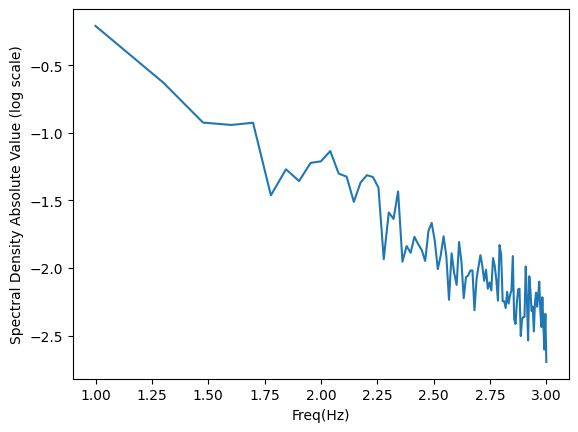

In [42]:
Gamma_fft = np.fft.fftshift(np.fft.fft(gamma))
Gamma_freq = np.fft.fftshift(np.fft.fftfreq(len(gamma), d=tau_list[1]-tau_list[0]))

Gamma_freq_p = Gamma_freq[Gamma_freq > 0]
Gamma_fft_p = Gamma_fft[Gamma_freq > 0]

Gamma_freq_plog = np.log10(Gamma_freq_p[Gamma_freq_p < 1000])
Gamma_fft_plog = np.log10(Gamma_fft_p[Gamma_freq_p < 1000])

plt.figure()
plt.plot(Gamma_freq_plog, Gamma_fft_plog)
plt.xlabel('Freq(Hz)')
plt.ylabel('Spectral Density Absolute Value (log scale)')

In [43]:
def func(t, b, a):
    return b + a * t

popt, pcov = curve_fit(func, Gamma_freq_plog, Gamma_fft_plog, p0 = [2, -0.5])

In [44]:
popt

array([ 0.74841427, -1.03879256])

Text(0, 0.5, 'Vertial Position')

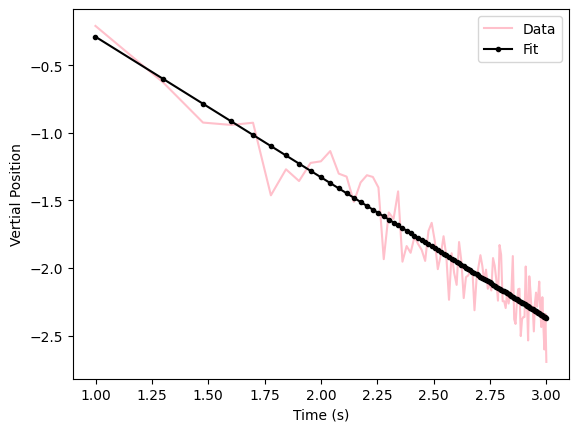

In [45]:
fig, ax = plt.subplots(1, 1)
ax.plot(Gamma_freq_plog, Gamma_fft_plog, label = 'Data', color='pink')
ax.plot(Gamma_freq_plog, func(Gamma_freq_plog, popt[0], popt[1]), marker='.', label = 'Fit', color='black')
ax.legend()
ax.set_xlabel('Time (s)')
ax.set_ylabel('Vertial Position')

### (5) Pink Noise (one trace) A=1 B=0.01

In [46]:
def Pink_Noise(min_freq, freq_repeat, t_end, t_repeat, mu, sigma, A, B):

  tlist = np.linspace(0, t_end, t_repeat)

  Chi_A = Chi_Ensemble(mu, sigma, freq_repeat)
  Chi_B = Chi_Ensemble(mu, sigma, freq_repeat)
  U_A = uniform(0, 2*np.pi, freq_repeat)
  U_B = uniform(0, 2*np.pi, freq_repeat)

  lst = []

  for k in range(freq_repeat):
    lst.append(A * (Chi_A[k]/np.sqrt((k+1)*min_freq)) * np.sin(2*np.pi*(k+1)*min_freq*tlist+U_A[k]) + B * Chi_B[k] * np.sin(2*np.pi*(k+1)*min_freq*tlist+U_B[k]))

  y = []
  for i in range(t_repeat):

    sum = 0
    for k in range(freq_repeat):
      sum = sum + lst[k][i]

    y.append(sum)

  Pink_Noise = np.array(y)

  return Pink_Noise

In [47]:
min_freq = 0.1
freq_repeat = 10000
t_repeat = 10000
t_end = 1

mu = 0
sigma = 0.01

A = 1
B = 0.01

Text(0, 0.5, 'Pink_Noise Distribution')

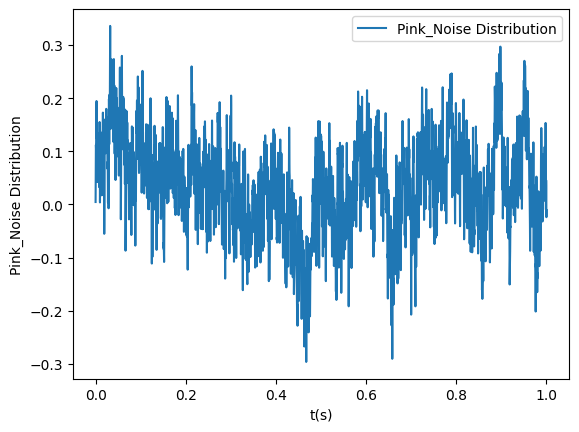

In [48]:
tlist = np.linspace(0, t_end, t_repeat)
Pink_Noise = Pink_Noise(min_freq, freq_repeat, t_end, t_repeat, mu, sigma, A, B)

fig, ax = plt.subplots(1, 1)
ax.plot(tlist, Pink_Noise, label = 'Pink_Noise Distribution')
ax.legend(loc = 0)
ax.set_xlabel('t(s)')
ax.set_ylabel('Pink_Noise Distribution')

Text(0, 0.5, 'FT Absolute Value (linear scale)')

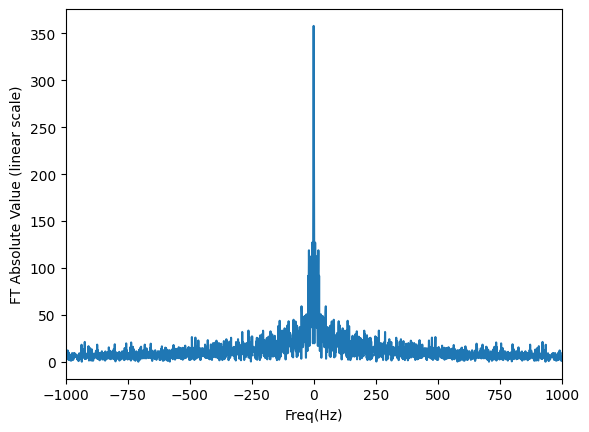

In [49]:
x_fft = np.fft.fftshift(np.fft.fft(Pink_Noise))
x_freq = np.fft.fftshift(np.fft.fftfreq(len(Pink_Noise), d=tlist[1]-tlist[0]))

plt.figure()
plt.plot(x_freq, np.abs(x_fft))
plt.xlim(-1000,1000)
plt.xlabel('Freq(Hz)')
plt.ylabel('FT Absolute Value (linear scale)')

Text(0, 0.5, 'FT Absolute Value (log scale)')

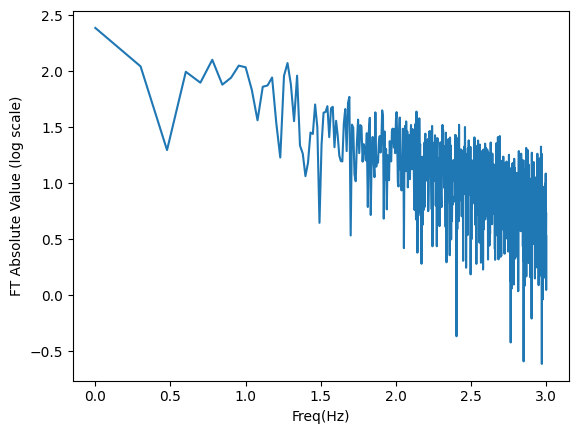

In [50]:
x_fft = np.fft.fftshift(np.fft.fft(Pink_Noise))
x_freq = np.fft.fftshift(np.fft.fftfreq(len(Pink_Noise), d=tlist[1]-tlist[0]))

x_freq_p = x_freq[x_freq > 0]
x_fft_p = x_fft[x_freq > 0]

x_freq_plog = np.log10(x_freq_p[x_freq_p < 1000])
x_fft_plog = np.log10(x_fft_p[x_freq_p < 1000])

plt.figure()
plt.plot(x_freq_plog, x_fft_plog)
plt.xlabel('Freq(Hz)')
plt.ylabel('FT Absolute Value (log scale)')

In [51]:
def func(t, b, a):
    return b + a * t

popt, pcov = curve_fit(func, x_freq_plog, x_fft_plog, p0 = [2, -0.5])

In [52]:
popt

array([ 2.26970781, -0.51266978])

Text(0, 0.5, 'Vertial Position')

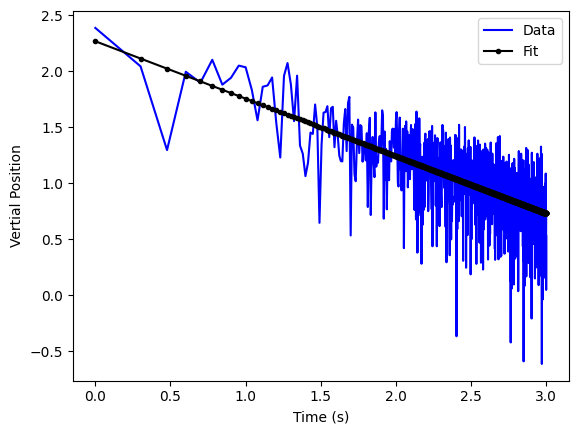

In [53]:
fig, ax = plt.subplots(1, 1)
ax.plot(x_freq_plog, x_fft_plog, label = 'Data', color='blue')
ax.plot(x_freq_plog, func(x_freq_plog, popt[0], popt[1]), marker='.', label = 'Fit', color='black')
ax.legend()
ax.set_xlabel('Time (s)')
ax.set_ylabel('Vertial Position')

In [54]:
gamma_list = []

tau_end = 500
num = 1000


for tau in range(-500, 500, 1):
  n = 0

  for i in range(1000, 9000, 1):
    n = n + Pink_Noise[i]*Pink_Noise[i+tau]

  gamma_list.append(n/8000)

gamma = np.array(gamma_list)
tau_list = np.linspace(-0.05, 0.05, 1000)

Text(0, 0.5, 'Auto Correlation')

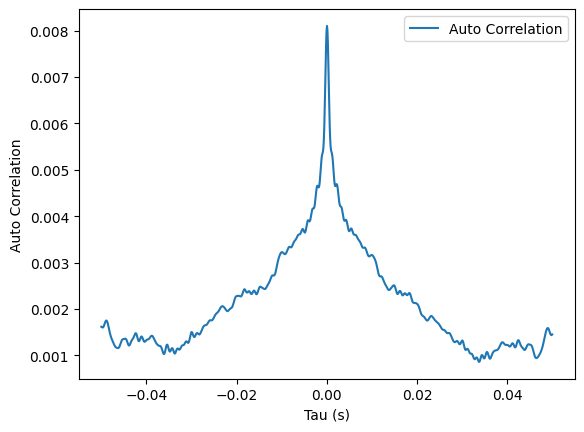

In [55]:
fig, ax = plt.subplots(1, 1)
ax.plot(tau_list, gamma, label = 'Auto Correlation')
ax.legend(loc = 0)
ax.set_xlabel('Tau (s)')
ax.set_ylabel('Auto Correlation')

Text(0, 0.5, 'Spectral Density Absolute Value (linear scale)')

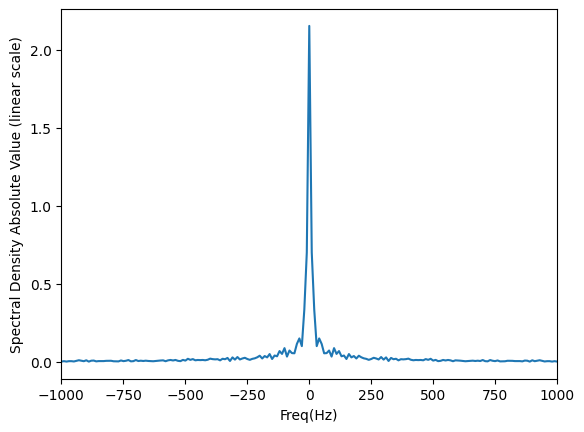

In [56]:
Gamma_fft = np.fft.fftshift(np.fft.fft(gamma))
Gamma_freq = np.fft.fftshift(np.fft.fftfreq(len(gamma), d=tau_list[1]-tau_list[0]))

plt.figure()
plt.plot(Gamma_freq, np.abs(Gamma_fft))
plt.xlim(-1000,1000)
plt.xlabel('Freq(Hz)')
plt.ylabel('Spectral Density Absolute Value (linear scale)')

Text(0, 0.5, 'Spectral Density Absolute Value (log scale)')

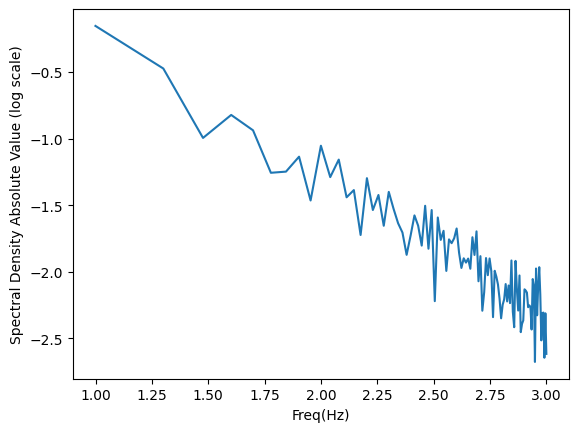

In [57]:
Gamma_fft = np.fft.fftshift(np.fft.fft(gamma))
Gamma_freq = np.fft.fftshift(np.fft.fftfreq(len(gamma), d=tau_list[1]-tau_list[0]))

Gamma_freq_p = Gamma_freq[Gamma_freq > 0]
Gamma_fft_p = Gamma_fft[Gamma_freq > 0]

Gamma_freq_plog = np.log10(Gamma_freq_p[Gamma_freq_p < 1000])
Gamma_fft_plog = np.log10(Gamma_fft_p[Gamma_freq_p < 1000])

plt.figure()
plt.plot(Gamma_freq_plog, Gamma_fft_plog)
plt.xlabel('Freq(Hz)')
plt.ylabel('Spectral Density Absolute Value (log scale)')

In [58]:
def func(t, b, a):
    return b + a * t

popt, pcov = curve_fit(func, Gamma_freq_plog, Gamma_fft_plog, p0 = [2, -0.5])

In [59]:
popt

array([ 0.83343443, -1.05028509])

Text(0, 0.5, 'Vertial Position')

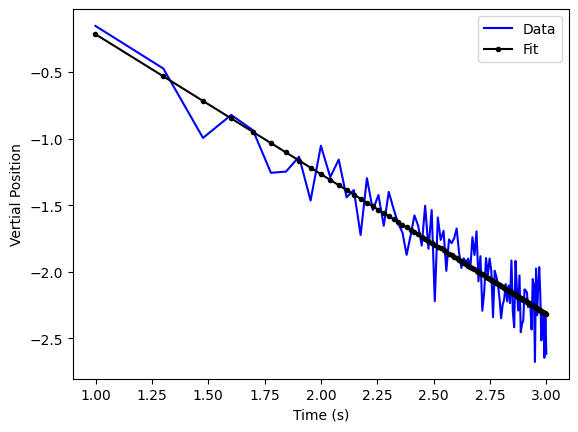

In [60]:
fig, ax = plt.subplots(1, 1)
ax.plot(Gamma_freq_plog, Gamma_fft_plog, label = 'Data', color='blue')
ax.plot(Gamma_freq_plog, func(Gamma_freq_plog, popt[0], popt[1]), marker='.', label = 'Fit', color='black')
ax.legend()
ax.set_xlabel('Time (s)')
ax.set_ylabel('Vertial Position')

### (6) Pink Noise (one trace) A=1 B=1

In [61]:
def Pink_Noise(min_freq, freq_repeat, t_end, t_repeat, mu, sigma, A, B):

  tlist = np.linspace(0, t_end, t_repeat)

  Chi_A = Chi_Ensemble(mu, sigma, freq_repeat)
  Chi_B = Chi_Ensemble(mu, sigma, freq_repeat)
  U_A = uniform(0, 2*np.pi, freq_repeat)
  U_B = uniform(0, 2*np.pi, freq_repeat)

  lst = []

  for k in range(freq_repeat):
    lst.append(A * (Chi_A[k]/np.sqrt((k+1)*min_freq)) * np.sin(2*np.pi*(k+1)*min_freq*tlist+U_A[k]) + B * Chi_B[k] * np.sin(2*np.pi*(k+1)*min_freq*tlist+U_B[k]))

  y = []
  for i in range(t_repeat):

    sum = 0
    for k in range(freq_repeat):
      sum = sum + lst[k][i]

    y.append(sum)

  Pink_Noise = np.array(y)

  return Pink_Noise

In [62]:
min_freq = 0.1
freq_repeat = 10000
t_repeat = 10000
t_end = 1

mu = 0
sigma = 0.01

A = 1
B = 1

Text(0, 0.5, 'Pink_Noise Distribution')

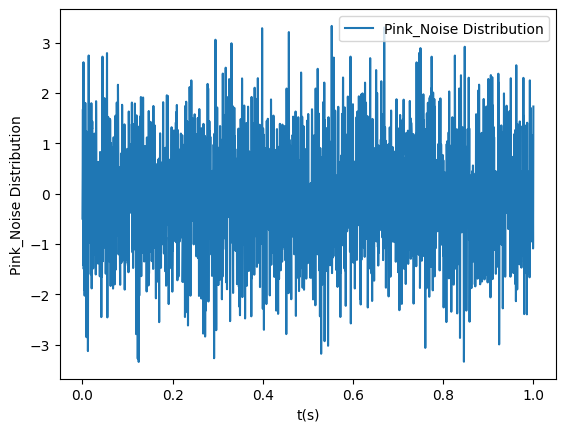

In [63]:
tlist = np.linspace(0, t_end, t_repeat)
Pink_Noise = Pink_Noise(min_freq, freq_repeat, t_end, t_repeat, mu, sigma, A, B)

fig, ax = plt.subplots(1, 1)
ax.plot(tlist, Pink_Noise, label = 'Pink_Noise Distribution')
ax.legend(loc = 0)
ax.set_xlabel('t(s)')
ax.set_ylabel('Pink_Noise Distribution')

Text(0, 0.5, 'FT Absolute Value (linear scale)')

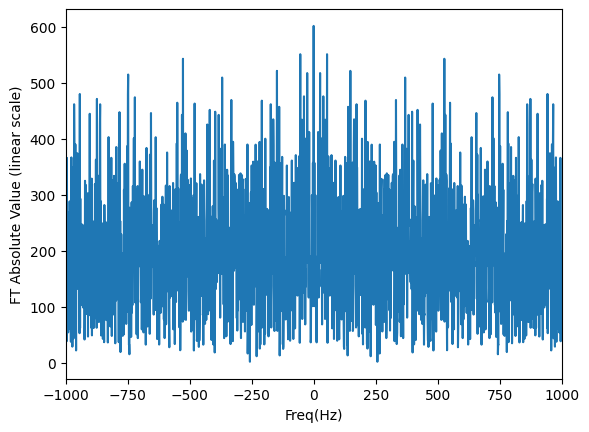

In [64]:
x_fft = np.fft.fftshift(np.fft.fft(Pink_Noise))
x_freq = np.fft.fftshift(np.fft.fftfreq(len(Pink_Noise), d=tlist[1]-tlist[0]))

plt.figure()
plt.plot(x_freq, np.abs(x_fft))
plt.xlim(-1000,1000)
plt.xlabel('Freq(Hz)')
plt.ylabel('FT Absolute Value (linear scale)')

Text(0, 0.5, 'FT Absolute Value (log scale)')

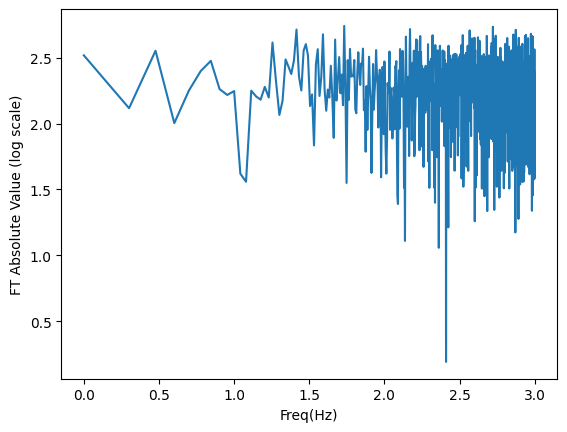

In [65]:
x_fft = np.fft.fftshift(np.fft.fft(Pink_Noise))
x_freq = np.fft.fftshift(np.fft.fftfreq(len(Pink_Noise), d=tlist[1]-tlist[0]))

x_freq_p = x_freq[x_freq > 0]
x_fft_p = x_fft[x_freq > 0]

x_freq_plog = np.log10(x_freq_p[x_freq_p < 1000])
x_fft_plog = np.log10(x_fft_p[x_freq_p < 1000])

plt.figure()
plt.plot(x_freq_plog, x_fft_plog)
plt.xlabel('Freq(Hz)')
plt.ylabel('FT Absolute Value (log scale)')

In [66]:
def func(t, b, a):
    return b + a * t

popt, pcov = curve_fit(func, x_freq_plog, x_fft_plog, p0 = [2, -0.5])

In [67]:
popt

array([ 2.30551526, -0.03444432])

Text(0, 0.5, 'Vertial Position')

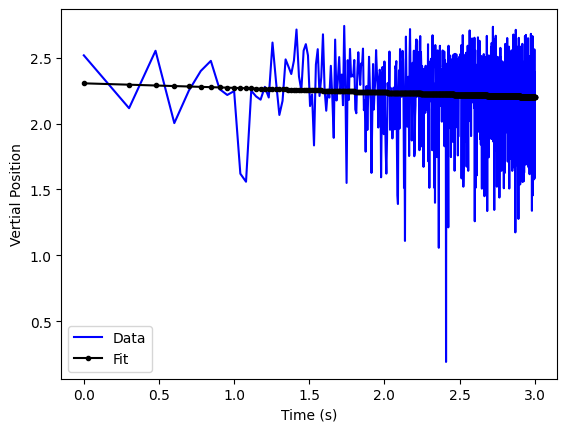

In [68]:
fig, ax = plt.subplots(1, 1)
ax.plot(x_freq_plog, x_fft_plog, label = 'Data', color='blue')
ax.plot(x_freq_plog, func(x_freq_plog, popt[0], popt[1]), marker='.', label = 'Fit', color='black')
ax.legend()
ax.set_xlabel('Time (s)')
ax.set_ylabel('Vertial Position')

In [69]:
gamma_list = []

tau_end = 500
num = 1000


for tau in range(-500, 500, 1):
  n = 0

  for i in range(1000, 9000, 1):
    n = n + Pink_Noise[i]*Pink_Noise[i+tau]

  gamma_list.append(n/8000)

gamma = np.array(gamma_list)
tau_list = np.linspace(-0.05, 0.05, 1000)

Text(0, 0.5, 'Auto Correlation')

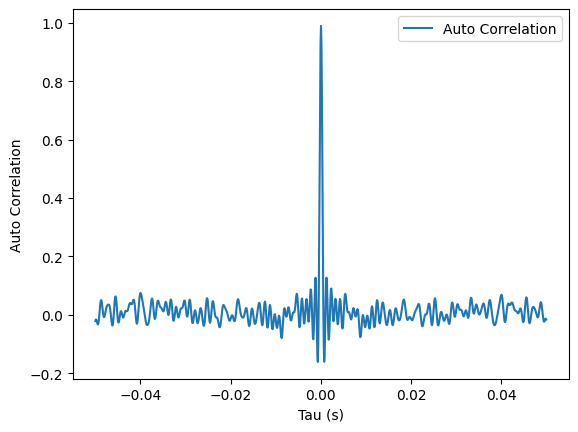

In [70]:
fig, ax = plt.subplots(1, 1)
ax.plot(tau_list, gamma, label = 'Auto Correlation')
ax.legend(loc = 0)
ax.set_xlabel('Tau (s)')
ax.set_ylabel('Auto Correlation')

Text(0, 0.5, 'Spectral Density Absolute Value (linear scale)')

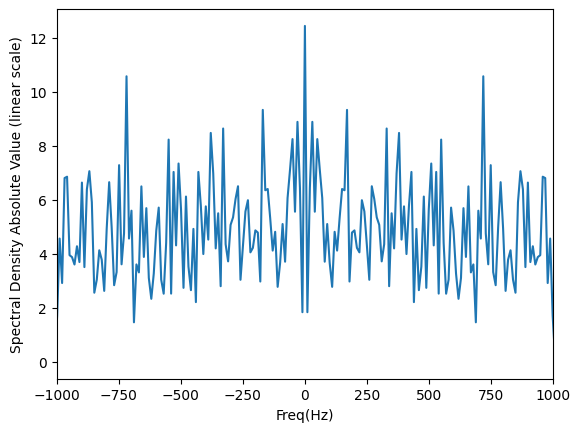

In [71]:
Gamma_fft = np.fft.fftshift(np.fft.fft(gamma))
Gamma_freq = np.fft.fftshift(np.fft.fftfreq(len(gamma), d=tau_list[1]-tau_list[0]))

plt.figure()
plt.plot(Gamma_freq, np.abs(Gamma_fft))
plt.xlim(-1000,1000)
plt.xlabel('Freq(Hz)')
plt.ylabel('Spectral Density Absolute Value (linear scale)')

Text(0, 0.5, 'Spectral Density Absolute Value (log scale)')

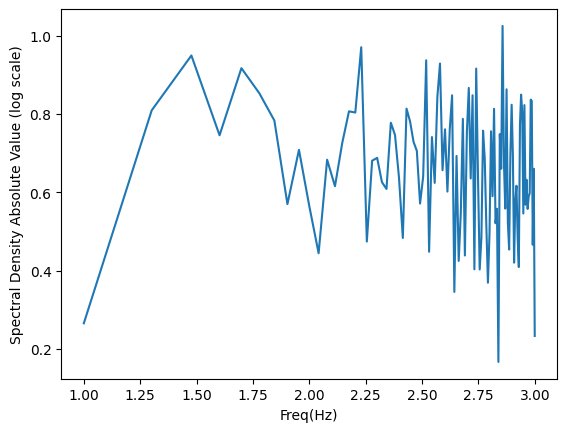

In [72]:
Gamma_fft = np.fft.fftshift(np.fft.fft(gamma))
Gamma_freq = np.fft.fftshift(np.fft.fftfreq(len(gamma), d=tau_list[1]-tau_list[0]))

Gamma_freq_p = Gamma_freq[Gamma_freq > 0]
Gamma_fft_p = Gamma_fft[Gamma_freq > 0]

Gamma_freq_plog = np.log10(Gamma_freq_p[Gamma_freq_p < 1000])
Gamma_fft_plog = np.log10(Gamma_fft_p[Gamma_freq_p < 1000])

plt.figure()
plt.plot(Gamma_freq_plog, Gamma_fft_plog)
plt.xlabel('Freq(Hz)')
plt.ylabel('Spectral Density Absolute Value (log scale)')

In [73]:
def func(t, b, a):
    return b + a * t

popt, pcov = curve_fit(func, Gamma_freq_plog, Gamma_fft_plog, p0 = [2, -0.5])

In [74]:
popt

array([ 0.81815931, -0.06227145])

Text(0, 0.5, 'Vertial Position')

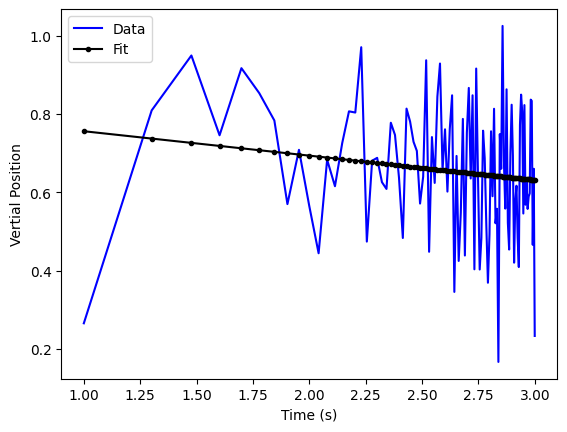

In [75]:
fig, ax = plt.subplots(1, 1)
ax.plot(Gamma_freq_plog, Gamma_fft_plog, label = 'Data', color='blue')
ax.plot(Gamma_freq_plog, func(Gamma_freq_plog, popt[0], popt[1]), marker='.', label = 'Fit', color='black')
ax.legend()
ax.set_xlabel('Time (s)')
ax.set_ylabel('Vertial Position')

### (7) Pink Noise (multi trace) A=1 B=0

In [76]:
def Pink_Noise(min_freq, freq_repeat, t_end, t_repeat, mu, sigma, A, B):

  tlist = np.linspace(0, t_end, t_repeat)

  Chi_A = Chi_Ensemble(mu, sigma, freq_repeat)
  Chi_B = Chi_Ensemble(mu, sigma, freq_repeat)
  U_A = uniform(0, 2*np.pi, freq_repeat)
  U_B = uniform(0, 2*np.pi, freq_repeat)

  lst = []

  for k in range(freq_repeat):
    lst.append(A * (Chi_A[k]/np.sqrt((k+1)*min_freq)) * np.sin(2*np.pi*(k+1)*min_freq*tlist+U_A[k]) + B * Chi_B[k] * np.sin(2*np.pi*(k+1)*min_freq*tlist+U_B[k]))

  y = []
  for i in range(t_repeat):

    sum = 0
    for k in range(freq_repeat):
      sum = sum + lst[k][i]

    y.append(sum)

  Pink_Noise = np.array(y)

  return Pink_Noise

In [77]:
def Pink_Noise_MultiTrace (num_ensemble, min_freq, freq_repeat, t_end, t_repeat, mu, sigma, A, B):

  ensemble_list = []

  for i in range(num_ensemble):
    Pink = Pink_Noise(min_freq, freq_repeat, t_end, t_repeat, mu, sigma, A, B)
    ensemble_list.append(Pink)

  normal_avg = []

  for i in range(freq_repeat):

    sum = 0

    for j in range(num_ensemble):
      sum = sum + ensemble_list[j][i]

    normal_avg.append(sum/num_ensemble)

  return np.array(normal_avg)

In [78]:
num_ensemble = 10

min_freq = 0.1
freq_repeat = 10000
t_repeat = 10000
t_end = 1

mu = 0
sigma = 0.01

A = 1
B = 0

Text(0, 0.5, 'Pink_Noise Distribution')

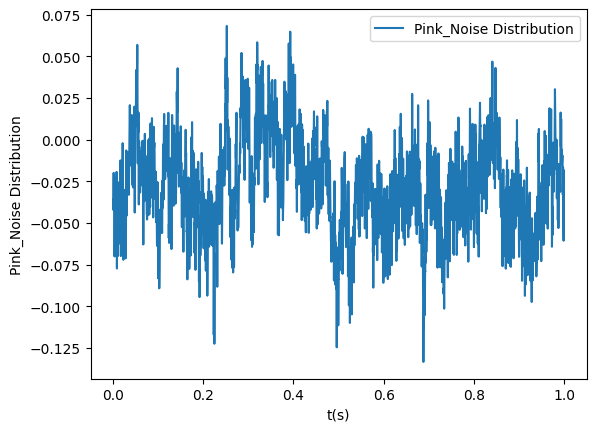

In [79]:
tlist = np.linspace(0, t_end, t_repeat)
Pink_Noise = Pink_Noise_MultiTrace(num_ensemble, min_freq, freq_repeat, t_end, t_repeat, mu, sigma, A, B)

fig, ax = plt.subplots(1, 1)
ax.plot(tlist, Pink_Noise, label = 'Pink_Noise Distribution')
ax.legend(loc = 0)
ax.set_xlabel('t(s)')
ax.set_ylabel('Pink_Noise Distribution')

Text(0, 0.5, 'FT Absolute Value (linear scale)')

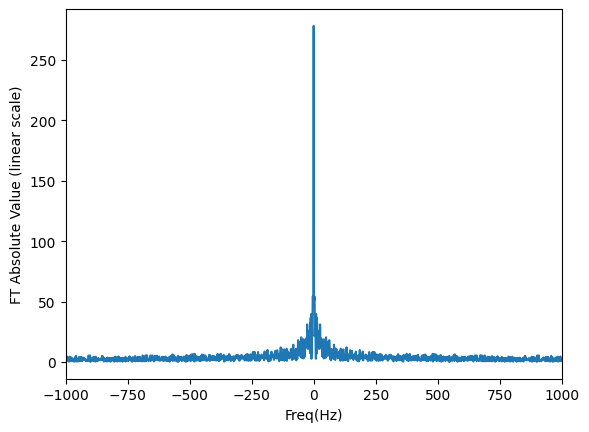

In [80]:
x_fft = np.fft.fftshift(np.fft.fft(Pink_Noise))
x_freq = np.fft.fftshift(np.fft.fftfreq(len(Pink_Noise), d=tlist[1]-tlist[0]))

plt.figure()
plt.plot(x_freq, np.abs(x_fft))
plt.xlim(-1000,1000)
plt.xlabel('Freq(Hz)')
plt.ylabel('FT Absolute Value (linear scale)')

Text(0, 0.5, 'FT Absolute Value (log scale)')

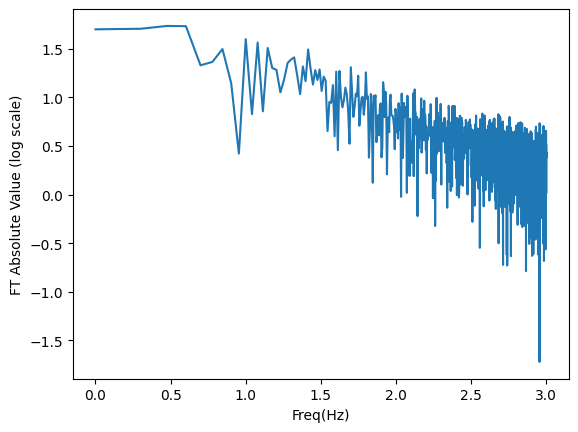

In [81]:
x_fft = np.fft.fftshift(np.fft.fft(Pink_Noise))
x_freq = np.fft.fftshift(np.fft.fftfreq(len(Pink_Noise), d=tlist[1]-tlist[0]))

x_freq_p = x_freq[x_freq > 0]
x_fft_p = x_fft[x_freq > 0]

x_freq_plog = np.log10(x_freq_p[x_freq_p < 1000])
x_fft_plog = np.log10(x_fft_p[x_freq_p < 1000])

plt.figure()
plt.plot(x_freq_plog, x_fft_plog)
plt.xlabel('Freq(Hz)')
plt.ylabel('FT Absolute Value (log scale)')

In [82]:
def func(t, b, a):
    return b + a * t

popt, pcov = curve_fit(func, x_freq_plog, x_fft_plog, p0 = [2, -0.5])

In [83]:
popt

array([ 1.86093898, -0.55162902])

Text(0, 0.5, 'Vertial Position')

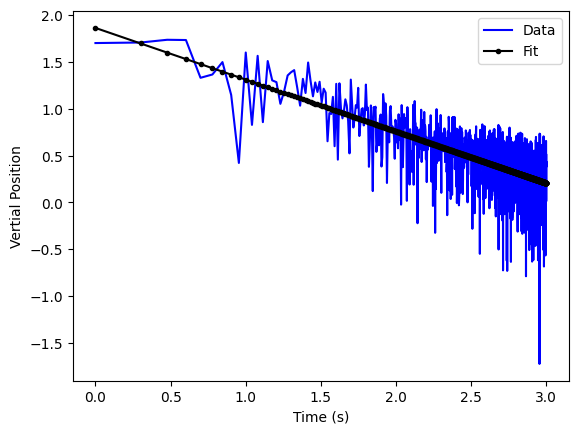

In [84]:
fig, ax = plt.subplots(1, 1)
ax.plot(x_freq_plog, x_fft_plog, label = 'Data', color='blue')
ax.plot(x_freq_plog, func(x_freq_plog, popt[0], popt[1]), marker='.', label = 'Fit', color='black')
ax.legend()
ax.set_xlabel('Time (s)')
ax.set_ylabel('Vertial Position')

In [85]:
gamma_list = []

tau_end = 500
num = 1000


for tau in range(-500, 500, 1):
  n = 0

  for i in range(1000, 9000, 1):
    n = n + Pink_Noise[i]*Pink_Noise[i+tau]

  gamma_list.append(n/8000)

gamma = np.array(gamma_list)
tau_list = np.linspace(-0.05, 0.05, 1000)

Text(0, 0.5, 'Auto Correlation')

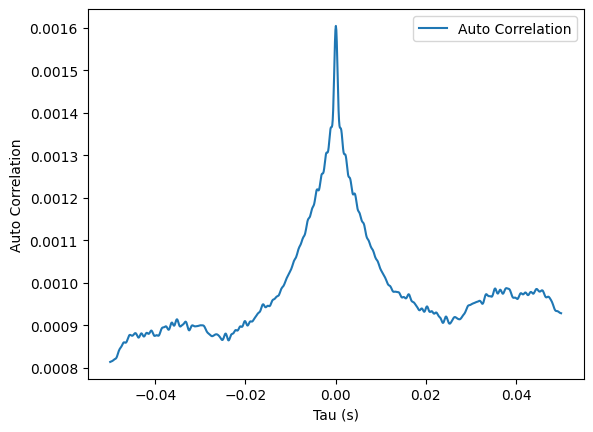

In [86]:
fig, ax = plt.subplots(1, 1)
ax.plot(tau_list, gamma, label = 'Auto Correlation')
ax.legend(loc = 0)
ax.set_xlabel('Tau (s)')
ax.set_ylabel('Auto Correlation')

Text(0, 0.5, 'Spectral Density Absolute Value (linear scale)')

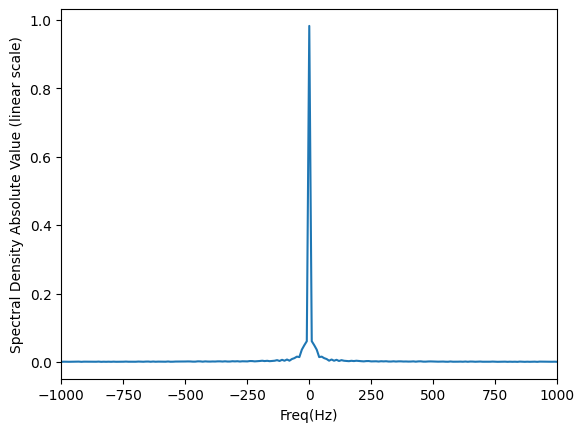

In [87]:
Gamma_fft = np.fft.fftshift(np.fft.fft(gamma))
Gamma_freq = np.fft.fftshift(np.fft.fftfreq(len(gamma), d=tau_list[1]-tau_list[0]))

plt.figure()
plt.plot(Gamma_freq, np.abs(Gamma_fft))
plt.xlim(-1000,1000)
plt.xlabel('Freq(Hz)')
plt.ylabel('Spectral Density Absolute Value (linear scale)')

Text(0, 0.5, 'Spectral Density Absolute Value (log scale)')

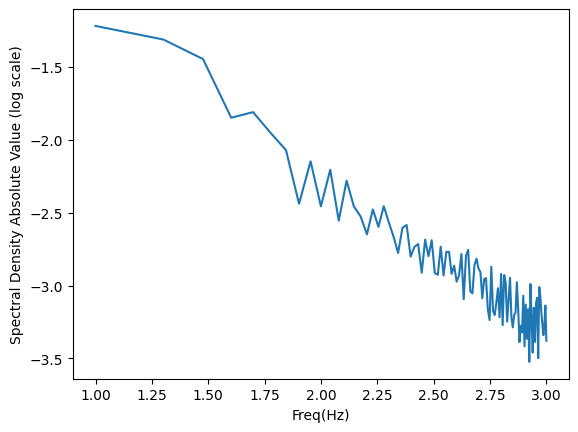

In [88]:
Gamma_fft = np.fft.fftshift(np.fft.fft(gamma))
Gamma_freq = np.fft.fftshift(np.fft.fftfreq(len(gamma), d=tau_list[1]-tau_list[0]))

Gamma_freq_p = Gamma_freq[Gamma_freq > 0]
Gamma_fft_p = Gamma_fft[Gamma_freq > 0]

Gamma_freq_plog = np.log10(Gamma_freq_p[Gamma_freq_p < 1000])
Gamma_fft_plog = np.log10(Gamma_fft_p[Gamma_freq_p < 1000])

plt.figure()
plt.plot(Gamma_freq_plog, Gamma_fft_plog)
plt.xlabel('Freq(Hz)')
plt.ylabel('Spectral Density Absolute Value (log scale)')

In [89]:
def func(t, b, a):
    return b + a * t

popt, pcov = curve_fit(func, Gamma_freq_plog, Gamma_fft_plog, p0 = [2, -0.5])

In [90]:
popt

array([-0.13441563, -1.05952725])

Text(0, 0.5, 'Vertial Position')

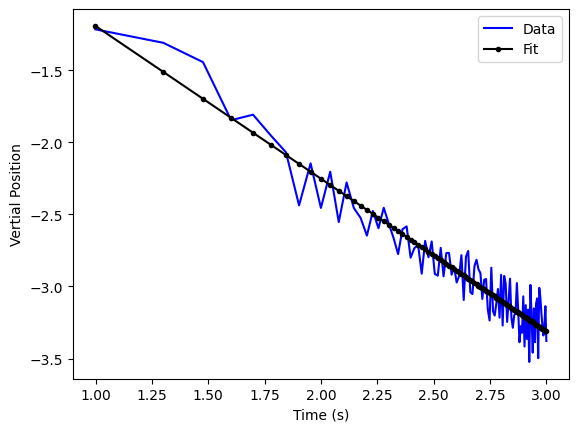

In [91]:
fig, ax = plt.subplots(1, 1)
ax.plot(Gamma_freq_plog, Gamma_fft_plog, label = 'Data', color='blue')
ax.plot(Gamma_freq_plog, func(Gamma_freq_plog, popt[0], popt[1]), marker='.', label = 'Fit', color='black')
ax.legend()
ax.set_xlabel('Time (s)')
ax.set_ylabel('Vertial Position')